# Reproducing Figures

This notebook presents an example of how to reproduce the figures published in 
the paper titled: *"A Bayesian Noisy Logic Model for Inference of Transcription
Factor Activity from Single Cell and Bulk Transcriptomic Data"*
([Arriojas et. al. 2023](https://doi.org/10.1101/2023.05.03.539308)).

The setup necessary for running the commands below is explained in the
[README](README.md) file.

Most of the code cells below display only a wrapper method that generates the desired
outputs. To see details of the corresponding code, we should inspect the
following scripts:
- `py_scripts/figures.py`
- `py_scripts/utils.py`
- `r_scripts/nlbayes_utils.R`
- `r_scripts/common_utils.R`

The cells should be run in order, at least the first time. This is because
some commands will generate intermediate `CSV` files that are used later.

First, we load the python modules

In [1]:
%load_ext rpy2.ipython
from py_scripts import figures, utils

By default the cells contain `python` code. However, we make use of the
`%%R` magic command to execute `R` code as necessary.

### Figure 3. Simulations
For this experiment we use the command line tool provided in the python package. 
The `nlb-simulation` command automatically generates simulated networks and
differential expression, performs randomization as specified by named parameters
and runs the inference algorithm to generate `CSV` files with the results. More
details can be found in the
[`simulation.py`](https://github.com/umbibio/nlbayes-python/blob/main/nlbayes/commands/simulation.py) script.

Note that we save time by only computing 3 replicas for each case, you may wish to set the
`--n_replica` to 20 to 30. The commands below perform computations only if necessary.

In [ ]:
# run simulation with no randomizations
!nlb-simulation --n_graphs 5 --n_replica 3 --net_seed  10 --evd_seed  20 --outdir ./data/simulations

# run simulations for data randomization experiments
!nlb-simulation --n_graphs 5 --n_replica 3 --net_seed  30 --evd_seed  40 --evd_rnd_p 0.25 --outdir ./data/simulations
!nlb-simulation --n_graphs 5 --n_replica 3 --net_seed  50 --evd_seed  60 --evd_rnd_p 0.50 --outdir ./data/simulations
!nlb-simulation --n_graphs 5 --n_replica 3 --net_seed  70 --evd_seed  80 --evd_rnd_p 0.75 --outdir ./data/simulations
!nlb-simulation --n_graphs 5 --n_replica 3 --net_seed  90 --evd_seed 100 --evd_rnd_p 1.00 --outdir ./data/simulations

# run simulations for network randomization experiments
!nlb-simulation --n_graphs 5 --n_replica 3 --net_seed  30 --evd_seed  40 --net_rnd_p 0.25 --outdir ./data/simulations
!nlb-simulation --n_graphs 5 --n_replica 3 --net_seed  50 --evd_seed  60 --net_rnd_p 0.50 --outdir ./data/simulations
!nlb-simulation --n_graphs 5 --n_replica 3 --net_seed  70 --evd_seed  80 --net_rnd_p 0.75 --outdir ./data/simulations
!nlb-simulation --n_graphs 5 --n_replica 3 --net_seed  90 --evd_seed 100 --net_rnd_p 1.00 --outdir ./data/simulations

After generating the results files, we can process them and make Figure 3 with the methods `collect_simulations` and `make_figure_3`.

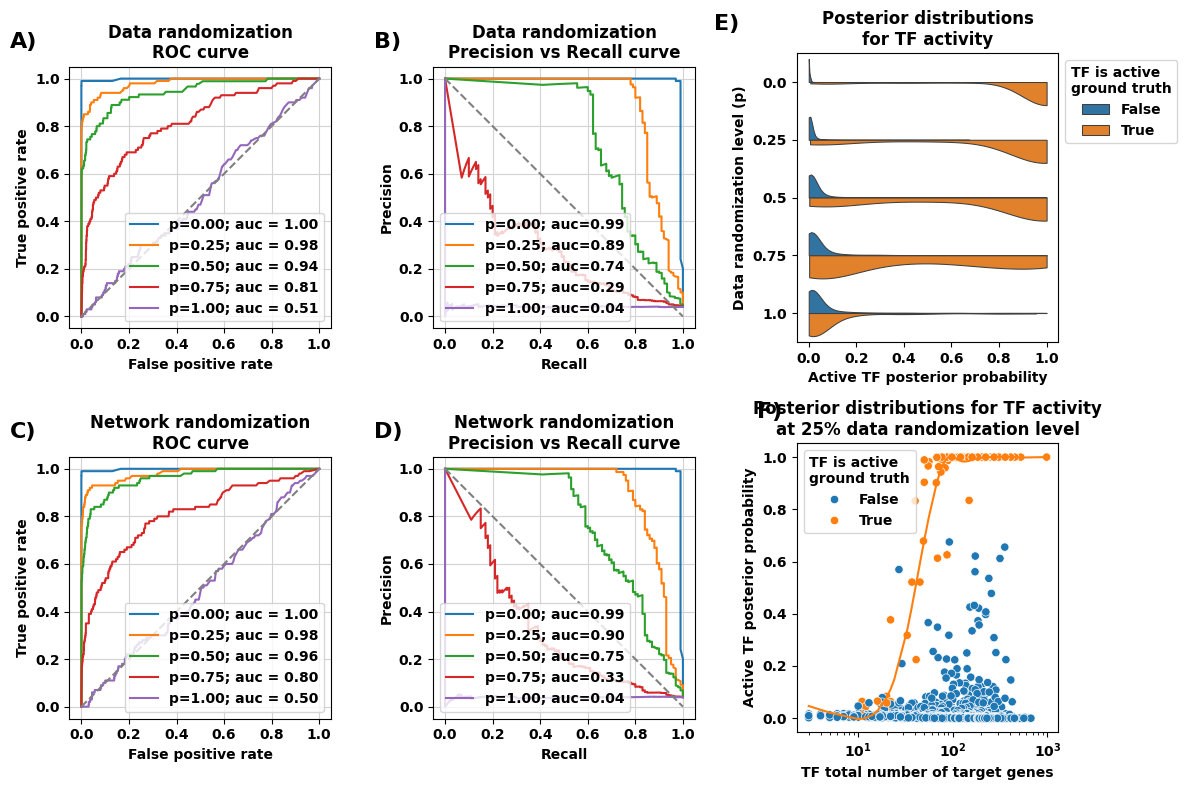

In [2]:
results, metadata = utils.collect_simulations('./data/simulations')
figures.make_figure_3(results)

### Figure 4. NLBayes vs Viper
First we generate the results for the TF activity inference from the two methods.
The R method `compute.inference.comparison` generates three `CSV` files, one for each experiment (e2f3, c-myc, h-ras).

In [ ]:
%%capture
%%R

source('r_scripts/nlbayes_utils.R')
compute.inference.comparison()

Once the corresponding `CSV` files are available, we can make the figure.

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


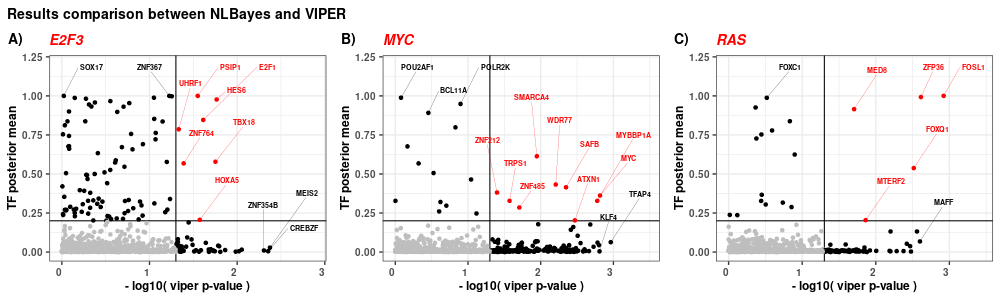

In [3]:
%%R -w 1000 -h 300 -u px

source('r_scripts/figures.R')
make.figure.4()

To assess for agreement between both methods, we construct the corresponding 
confusion matrix and use it as a contingency matrix in a fisher exact test
with the 'greater' alternative hypothesis, i.e., the true odds ratio is greater
than one.

In [4]:
%%R

for (exp in c('e2f3', 'myc', 'ras')) {

    # read result
    filename <- paste0('data/oe_',exp,'_on_net_regulonbrca_nlbayes_and_viper.csv')
    df <- read.table(filename, sep = ',', header = TRUE)
    df$viper.pvalue[is.na(df$viper.pvalue)] <- 1

    # compute contingency table
    yy <- sum(df$posterior.p >= 0.2 & df$viper.pvalue <= 0.05)
    yn <- sum(df$posterior.p >= 0.2 & df$viper.pvalue > 0.05)
    ny <- sum(df$posterior.p < 0.2 & df$viper.pvalue <= 0.05)
    nn <- sum(df$posterior.p < 0.2 & df$viper.pvalue > 0.05)
    ctable <- matrix(c(yy, ny, yn, nn), nrow=2, ncol=2)

    test.result <- fisher.test(ctable, alternative='greater')

    # print test
    cat("Experiment ", exp, "\n")
    cat("P-value for the agreement between NLBayes and VIPER:", test.result$p.value, "\n\n")

}

Experiment  e2f3 
P-value for the agreement between NLBayes and VIPER: 0.03383889 

Experiment  myc 
P-value for the agreement between NLBayes and VIPER: 0.0006798171 

Experiment  ras 
P-value for the agreement between NLBayes and VIPER: 0.002943375 



### Fig. 5. Comparison to other methods

To make figure 5, the `CSV` files from the previous step are needed.

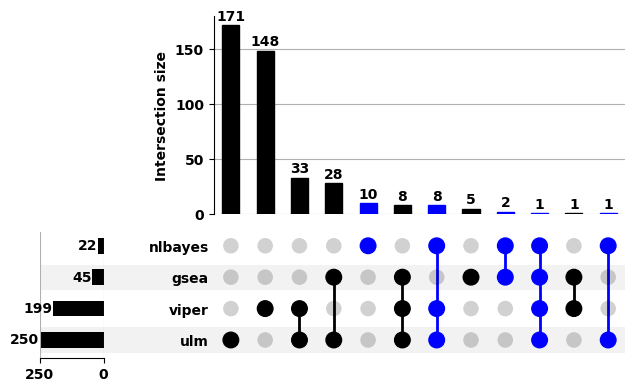

In [5]:
figures.make_figure_5()

### Figure 6. Cell lines single-cell

In [6]:
%%capture
%%R

source('r_scripts/figures.R')
f6 <- make.figure.6()

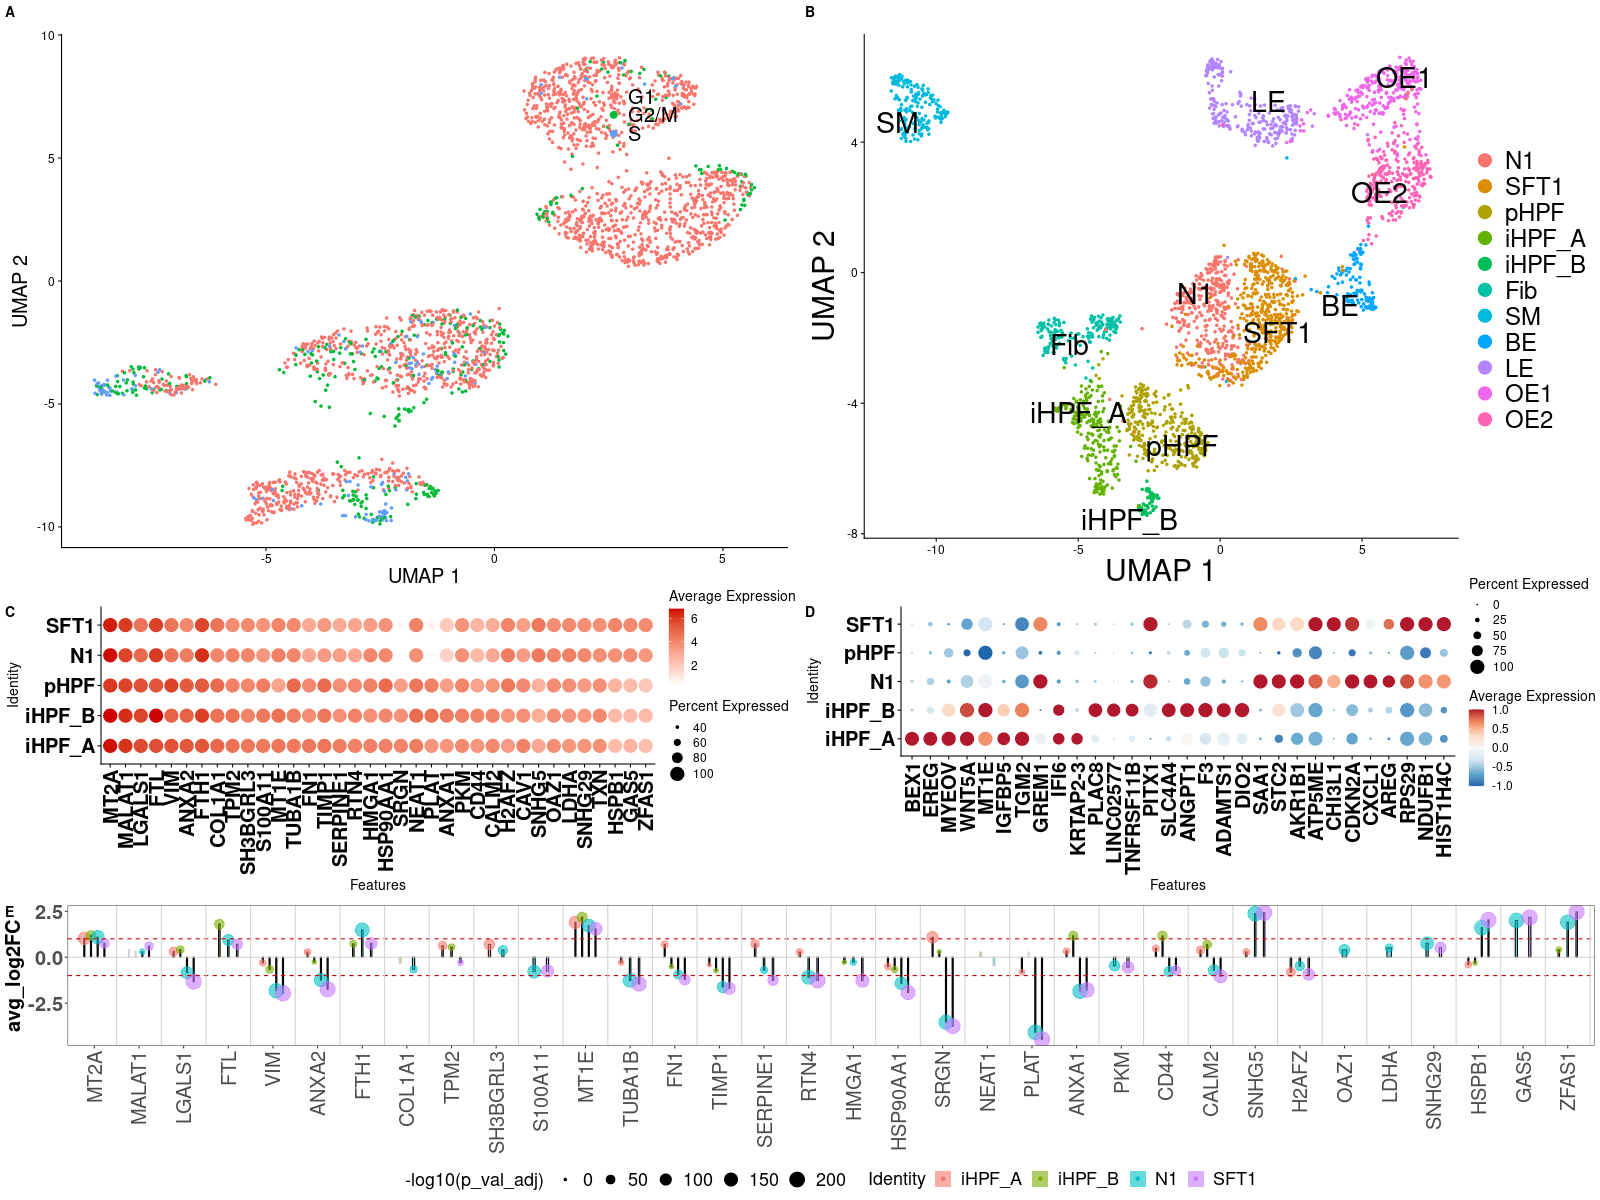

In [7]:
%%R -w 1600 -h 1200 -u px
f6

### Figure 7. GO enrichment

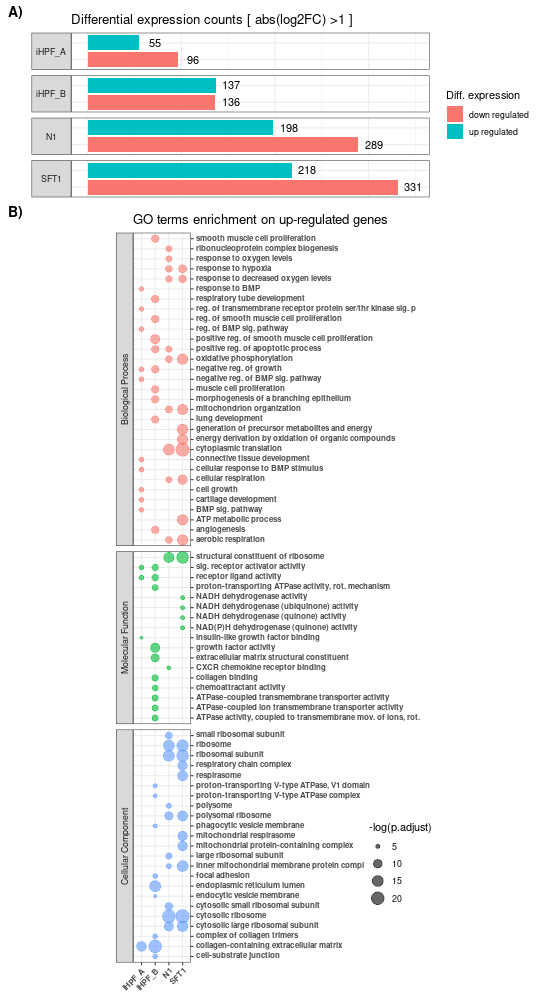

In [8]:
%%R -w 550 -h 1000 -u px
source('r_scripts/figures.R')
make.figure.7()

### Figure 8. TF activity inference on cell lines

Figure 8 requires computing the TF activity inference with NLBayes, on the
differential expression data for each cell line versus the primary cells.
The function `compute.sc.inference` computes the corresponding tables.

In [ ]:
%%capture
%%R
source('r_scripts/nlbayes_utils.R')
compute.sc.inference()

In [9]:
%%capture
%%R
source('r_scripts/figures.R')
f8 <- make.figure.8()

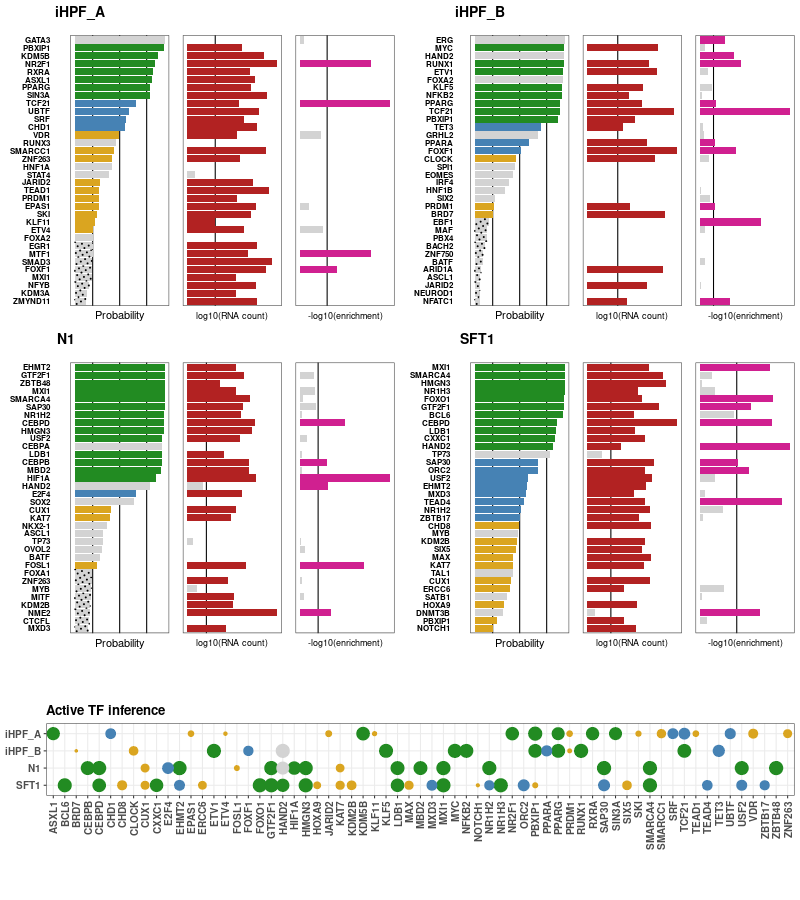

In [10]:
%%R -w 800 -h 900 -u px
f8